## Libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import sys

# Normal Network

## Plot Helper

In [32]:
def ploter(t, s):
# dark blue, orange, red, brown, green, black
    plt.plot(t, s[:,0], label='S', color='#000080')
    plt.plot(t, s[:,1], label='E', color='#FFA500')
    plt.plot(t, s[:,2], label='I', color='#FF0000')
    plt.plot(t, s[:,3], label='H', color='#8B4513')
    plt.plot(t, s[:,4], label='R', color='#008000')
    plt.plot(t, s[:,5], label='K', color='#000000')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Fraction of population')
    # display only 3 ticks on the x-axis
    plt.xticks(np.linspace(0, t[-1], 3))
    # display only 5 ticks on the y-axis
    plt.yticks(np.linspace(0, 1, 5))
    plt.show()
    return


## Model

In [93]:
def f(s,t):
    # alpha -> a0
    # beta -> b
    # sigma -> s
    # gamma -> g
    # Xi -> x
    # chi -> c


    # Parameters
    global a0, a1, si, b, g, c, x
    
    S, E, I, H, R, K = s
    N = S + E + I + H + R # Total population
    a_k = a0 + a1*K

    dsdt = -b*S*I/N
    dedt = b*S*I/N - si*E
    didt = si*E - a_k*I
    dhdt = a_k*I - g*H
    drdt = g*H
    dkdt = x*I - c*K
    return [dsdt, dedt, didt, dhdt, drdt, dkdt]


## Test and plot for R = 6, test kits = 0

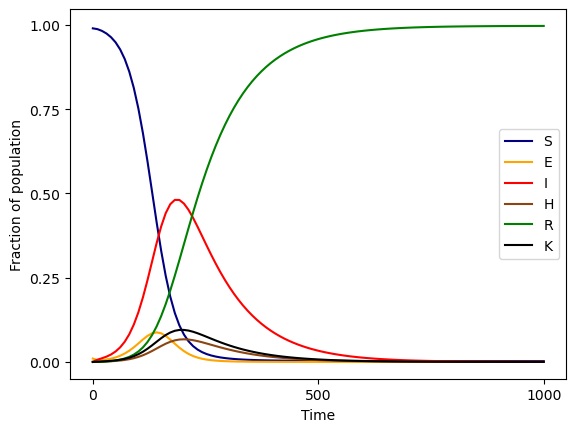

In [114]:
# initial conditions
a0, a1, si, b, g, c, x = 0.01, 0, 0.1, 0.06, 0.07, 0.1, 0.02
s0 = [0.99, 0.01, 0, 0, 0, 0]
t = np.linspace(0, 1000,100)
s = odeint(f, s0, t)
ploter(t, s)

## Test and plot for R = 3 with intervention of test kits

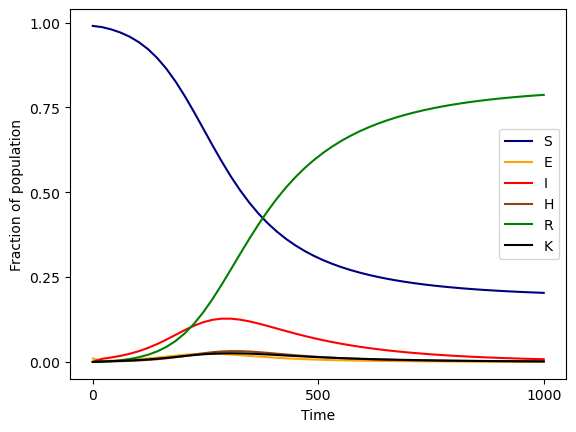

In [122]:
# initial conditions
a0, a1, si, b, g, c, x = 0.01, 0.3, 0.1, 0.03, 0.07, 0.1, 0.02
s0 = [0.99, 0.01, 0, 0, 0, 0]
t = np.linspace(0, 1000)
s = odeint(f, s0, t)
ploter(t, s)

## Plot of $I_{max}$

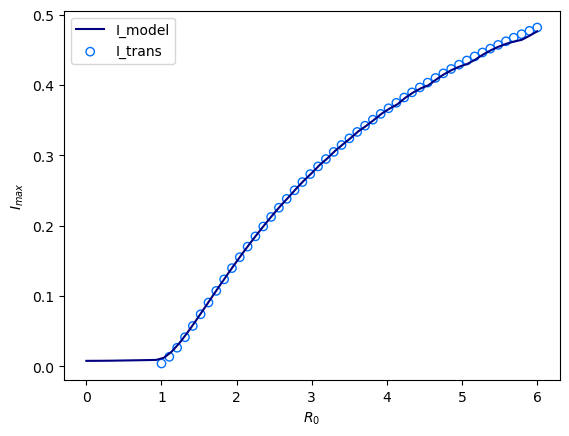

In [166]:
a0, a1, si, b, g, c, x = 0.01, 0.0, 0.1, 0.03, 0.07, 0.1, 0.02
s0 = [0.99, 0.01, 0, 0, 0, 0]
t = np.linspace(0, 1000)
I = []
Ia = []
Z = []
for i in range(1, 60):
    b = i/1000
    R = b/a0
    s = odeint(f, s0, t)
    I.append(max(s[:,2]))
    if R < 1:
        Ia.append(0)
    else:
        Ia.append(si*1/(si+a0)*(1-((1+np.log(R))/R)))
    Z.append(1-min(s[:,0]))

plt.plot(np.linspace(0, 6, 59), I, label='I_model', color='#000080')
# hollowcirlces
plt.scatter(np.linspace(1, 6, 49), Ia[10:], label='I_trans', color='#006FFF', marker='o', facecolors='none')
plt.xlabel('$R_0$')
plt.ylabel('$I_{max}$')
plt.legend()
plt.show()

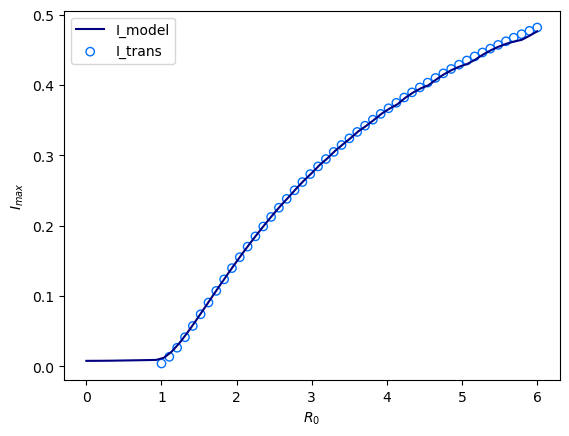

In [ ]:
a0, a1, si, b, g, c, x = 0.01, 0.0, 0.1, 0.03, 0.07, 0.1, 0.02
s0 = [0.99, 0.01, 0, 0, 0, 0]
t = np.linspace(0, 1000)
I = []
Ia = []
Z = []
for i in range(1, 60):
    b = i/1000
    R = b/a0
    s = odeint(f, s0, t)
    I.append(max(s[:,2]))
    if R < 1:
        Ia.append(0)
    else:
        Ia.append(si*1/(si+a0)*(1-((1+np.log(R))/R)))
    Z.append(1-min(s[:,0]))

plt.plot(np.linspace(0, 6, 59), I, label='I_model', color='#000080')
# hollowcirlces
plt.scatter(np.linspace(1, 6, 49), Ia[10:], label='I_trans', color='#006FFF', marker='o', facecolors='none')
plt.xlabel('$R_0$')
plt.ylabel('$I_{max}$')
plt.legend()
plt.show()

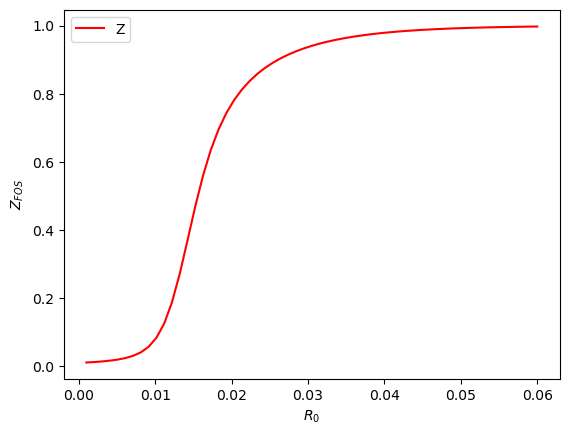

In [167]:
plt.plot(np.linspace(0.001, 0.06, 59), Z, label='Z', color='#FF0000')
plt.xlabel('$R_0$')
plt.ylabel('$Z_{FOS}$')
plt.legend()
plt.show()

# Meta Population Network

### PLotter

In [2]:

def multi_ploter(t, s, K, i):
# dark blue, orange, red, brown, green, black
    y = 5*i
    
    plt.plot(t, s[:,y+0], label=f'S$_{i}$', color='#000080')
    plt.plot(t, s[:,y+1], label=f'E$_{i}$', color='#FFA500')
    plt.plot(t, s[:,y+2], label=f'I$_{i}$', color='#FF0000')
    plt.plot(t, s[:,y+3], label=f'H$_{i}$', color='#8B4513')
    plt.plot(t, s[:,y+4], label=f'R$_{i}$', color='#008000')
    plt.plot(t, s[:,y+5], label=f'K$_{i}$', color='#000000')
    
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Fraction of population')
    # display only 3 ticks on the x-axis
    # plt.xticks(np.linspace(0, t[-1], 3))
    # display only 5 ticks on the y-axis
    # plt.yticks(np.linspace(0, 1, 5))
    plt.show()
    return


### Dynamics $X_i = \Sigma^M_{m=1} A_{im}*(S_m-S_i)$

In [75]:
# create A as a 2D array of random numbers
A = np.random.rand(4, 4)
# b as a 1D array from 1 to 6
b = np.arange(1, 5)
# print A@b, A*b, np.dot(A, b), matmul(A, b) in Python 3.5+ each on a new line
# print(A@b)
# print(A*b)
# print(np.dot(A, b))
# print(np.matmul(A, b))

A[0] = 1
A[1] = 2
A[2] = 3
A[3] = 4

b[0] = 10
b[1] = 20
print(np.dot(A, b))


[ 37.  74. 111. 148.]


In [25]:
def f(s,t):
    # alpha -> a0
    # beta -> b
    # sigma -> si
    # gamma -> g
    # Xi -> x
    # chi -> c
    # epsilon -> e
    # probability -> p


    # Parameters
    global a0, a1, si, b, g, c, x, e, p
    # Population network
    global M
    sn = len(M)
    # convert s to 2D array
    K = s[-1]
    # remove K from s
    s = np.array(s[:-1])
    s = s.reshape(sn, 5)
    s = s.T

    # print(s)
    S, E, I, H, R= s
    S = np.array(S.reshape(sn,1))
    E = np.array(E.reshape(sn,1))
    I = np.array(I.reshape(sn,1))
    H = np.array(H.reshape(sn,1))
    R = np.array(R.reshape(sn,1))
    
    K = 1
    N = S + E + I + H + R # Total population
    # print(a0,a1,K)
    a_k = a0 + a1*p*K
    # print(a_k)
    a_k = np.array(a_k.reshape(sn,1))
    # print(a_k)
    # sys.stdout.flush()

    # print(a_k)
    dsdt = np.zeros((sn,1))
    dedt = np.zeros((sn,1))
    didt = np.zeros((sn,1))
    dhdt = np.zeros((sn,1))
    drdt = np.zeros((sn,1))
    # dkdt = -c*K
    

    d = M.degree() # degree of each node
    d = np.array(d)[:,1:] # remove node number
    A = nx.adjacency_matrix(M) # adjacency matrix
    A = np.array(A.toarray())
    dkdt = -c*K

    print((e/d).shape,(np.sum(A * (S.reshape(-1,1) - S), axis=1)).shape)
    # flush
    sys.stdout.flush()
    dsdt = -b*S*I/N + (e/d)*np.sum(A * (S.reshape(-1,1) - S), axis=1)
    dedt = b*S*I/N - si*E + (e/d)*np.sum(A * (E.reshape(-1,1) - E), axis=1)
    didt = si*E - a_k*I + (e/d)*np.sum(A * (I.reshape(-1,1) - I), axis=1)
    drdt = g*H + (e/d)*np.sum(A * (R.reshape(-1,1) - R), axis=1)
    dhdt = a_k*I - g*H 
    dkdt = x*np.sum(I) - c*K

    # dsdt += + e/d*np.sum(A * (S - S[:, np.newaxis])[:, :, np.newaxis], axis=1)

    # for i in range(sn):
    #     dsdt[i] = -b[i]*S[i]*I[i]/N[i]
    #     dedt[i] = b[i]*S[i]*I[i]/N[i] - si*E[i]
    #     didt[i] = si*E[i] - a_k[i]*I[i]
    #     dhdt[i] = a_k[i]*I[i] - g*H[i]
    #     drdt[i] = g*H[i]
    #     dkdt += x*I[i]
    #     for j in range(sn):
    #         dsdt[i] += e/d[i]*A[i][j]*(S[j]-S[i])
    #         dedt[i] += e/d[i]*A[i][j]*(E[j]-E[i])
    #         didt[i] += e/d[i]*A[i][j]*(I[j]-I[i])
    #         drdt[i] += e/d[i]*A[i][j]*(R[j]-R[i])

    
    # return 1D array
    temp = []
    for i in range(sn):
        # convert dsdt[i] to value and append to temp
        temp.append(dsdt[i][0])
        temp.append(dedt[i][0])
        temp.append(didt[i][0])
        temp.append(dhdt[i][0])
        temp.append(drdt[i][0])
        # temp.append(dsdt[i])
        # temp.append(dedt[i])
        # temp.append(didt[i])
        # temp.append(dhdt[i])
        # temp.append(drdt[i])
    temp.append(dkdt)
    

    # print(dsdt.shape, dedt.shape, didt.shape, dhdt.shape, drdt.shape, dkdt.shape)
    # print(dsdt)
    # print(np.array(temp).shape)
    # make sure to return a 1D array
    # print(np.array(temp).flatten())
    # sys.stdout.flush()

    # return np.array(temp).flatten()
    return temp

### Parameters

In [3]:
# create a meta population network with m communities and n poeple per community
m = 10 # avg degree
n = 20 # number of communities
M = nx.barabasi_albert_graph(n, m)
# G = nx.barabasi_albert_graph(M, d)

# different initial conditions for all the m communities
s0 = []
temp = [0.99, 0.01, 0, 0, 0]
for i in range(n):
    de = i+1
    temp = [100-de, de, 0, 0, 0]
    s0 = s0 + temp # S, E, I, H, R
# initial conditions for each community in the network
s0.append(0) # K
a0 = 0.01
a1 = 0.3
# p = np.ones(n)/sn # equal distribution of testkits
# p = np.zeros(n)
# temp = np.array(sorted(M.degree(), key=lambda x: x[1], reverse=True)[:2])
# p[temp[:,0]] = temp[:,1]/sum(temp[:,1]) # degree distribution of testkits SD
# print(p)
si = 0.1
b = 0.03*np.ones(n) #
g = 0.07
c = 0.1
x = 0.02
e = 0.1 # migration strength


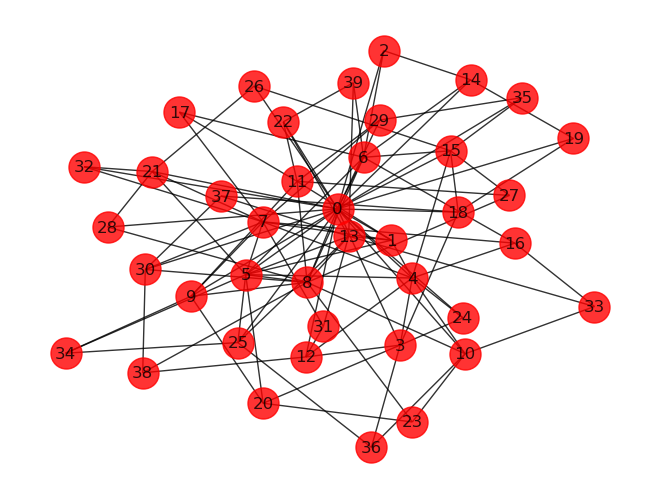

In [7]:
m = 3 # avg degree
n = 40 # number of communities
M = nx.barabasi_albert_graph(n, m)
# visualize the network
pos = nx.spring_layout(M)
nx.draw(M, pos, with_labels=True, node_color='r', node_size=500, alpha=0.8)
# plt.show()

### I for SC,SI,SD,SB

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\Asus pc\AppData\Local\Temp\ipykernel_10404\2517180568.py:38: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(M) # adjacency matrix
100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


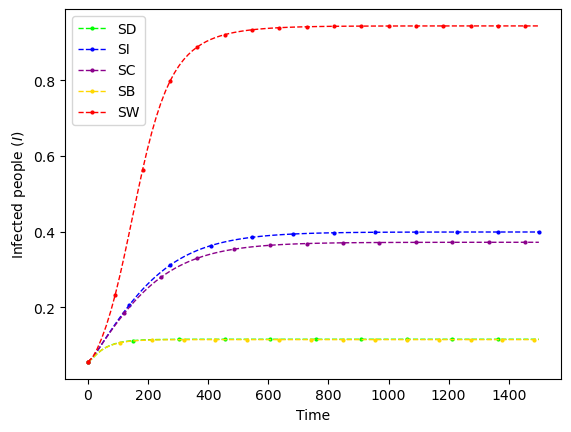

In [39]:
P = [] # store all the probabilities for SW,SD,SI,SB,SC
p = np.zeros(n)
Nd = 0.3 # fraction of nodes to be provided with kits
z = int(Nd*sn)

#------------------------------------------------------------
temp = np.array(sorted(M.degree(), key=lambda x: x[1], reverse=True)[:z])
p[temp[:,0]] = temp[:,1]/sum(temp[:,1]) # degree distribution of testkits SD
P.append(p)
#------------------------------------------------------------
p = np.zeros(n)
temp = np.array(sorted(M.degree(), key=lambda x: x[1], reverse=False)[:z])
p[temp[:,0]] = temp[:,1]/sum(temp[:,1]) # degree distribution of testkits SI
P.append(p) 
#------------------------------------------------------------
p = np.zeros(n)
temp = np.array(sorted(np.array(list(nx.clustering(M).items())), key=lambda x: x[1], reverse=True)[:z])
# print(temp)
p[temp[:,0].astype(int)] = temp[:,1]/sum(temp[:,1]) # degree distribution of testkits SC
P.append(p)
#------------------------------------------------------------
p = np.zeros(n)
temp = np.array(sorted(np.array(list(nx.betweenness_centrality(M).items())), key=lambda x: x[1], reverse=True)[:z])
# print(temp)
p[temp[:,0].astype(int)] = temp[:,1]/sum(temp[:,1]) # degree distribution of testkits SB
P.append(p)
#------------------------------------------------------------
# print(p)

t = np.linspace(0, 1500,100) # time
I = [] # store all the infected people
Z = []
a1 = 0.3
P.append(np.zeros(n)) # no distribution of testkits

temp = np.zeros(len(t))
names = ['SD', 'SI', 'SC', 'SB', 'SW']
# colors are green blue dark yellow red and black
colors = ['#00FF00', '#0000FF', '#8B008B', '#FFD700', '#FF0000', '#000000']
for j in tqdm(range(len(P))):
    p = P[j]
    if j == len(P):
        a1 = 0
    # print(j,p)
    # print(p)
    s = odeint(f, s0, t)
    K = s[:,-1]
    s = s[:,:-1]
    temp = np.zeros(len(t))
    tempz = np.zeros(len(t))
    for i in range(n):
        y = 5*i
        temp += s[:,y+2]
        tempz += 100 - s[:,y]
    I.append(temp)
    Z.append(tempz)
    plt.plot(t, tempz/(100*n), label=names[j], color=colors[j],marker='o', markevery=10-j, markersize=2,linestyle='dashed', linewidth=1)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Infected people ($I$)')
plt.show()


### $I_{max}$

In [26]:
m = 2 # avg degree
n = 10 # number of communities
M = nx.barabasi_albert_graph(n, m)
e = 0.2 # migration strength
s0 = []
temp = [0.99, 0.01, 0, 0, 0]
for i in range(n):
    de = i+1
    temp = [100-np.round(de/10), de, 0, 0, 0]
    s0 = s0 + temp # S, E, I, H, R
# initial conditions for each community in the network
s0.append(0) # K
s1 = s0.copy()
step = 10

# for e in [0.005,0.01,0.04,0.07,0.11,0.15]:
# for e in [0.01,0.04,0.07,0.3]:
for e in [0.001]:
    I = [] # store all the infected people
    for y in tqdm(range(1,step+1)):
        s0 = s1.copy()
        b = 0.03*np.ones((n,1)) #
        P = [] # store all the probabilities for SW,SD,SI,SB,SC
        p = np.zeros(n)
        Nd = y/step # fraction of nodes to be provided with kits
        z = int(Nd*len(M))

        #------------------------------------------------------------
        temp = np.array(sorted(M.degree(), key=lambda x: x[1], reverse=True)[:z])
        p[temp[:,0]] = temp[:,1]/sum(temp[:,1]) # degree distribution of testkits SD
        P.append(p)
        #------------------------------------------------------------
        p = np.zeros(n)
        temp = np.array(sorted(M.degree(), key=lambda x: x[1], reverse=False)[:z])
        p[temp[:,0]] = temp[:,1]/sum(temp[:,1]) # degree distribution of testkits SI
        P.append(p) 
        #------------------------------------------------------------
        p = np.zeros(n)
        temp = np.array(sorted(np.array(list(nx.clustering(M).items())), key=lambda x: x[1], reverse=True)[:z])
        # print(temp)
        p[temp[:,0].astype(int)] = temp[:,1]/sum(temp[:,1]) # degree distribution of testkits SC
        P.append(p)
        #------------------------------------------------------------
        p = np.zeros(n)
        temp = np.array(sorted(np.array(list(nx.betweenness_centrality(M).items())), key=lambda x: x[1], reverse=True)[:z])
        # print(temp)
        p[temp[:,0].astype(int)] = temp[:,1]/sum(temp[:,1]) # degree distribution of testkits SB
        P.append(p)
        #------------------------------------------------------------
        # print(p)

        t = np.linspace(0, 1000,50) # time
        a1 = 0.3
        P.append(np.zeros(n)) # no distribution of testkits

        temp = np.zeros(len(t))

        for j in range(len(P)):
            p = P[j]
            if j == len(P): # no test kits
                a1 = 0
            # print(j,p)
            # print(p)
            s = odeint(f, s0, t)
            K = s[:,-1]
            s = s[:,:-1]
            temp = np.zeros(len(t))
            for i in range(n):
                y = 5*i
                temp += s[:,y+2]
            I.append(max(temp))

    names = ['SD', 'SI', 'SC', 'SB', 'SW']
    Imax = np.array(I)
    # convert into 2d array
    Imax = Imax.reshape(step,len(P))
    # colors are green blue dark yellow red and black
    colors = ['#00FF00', '#0000FF', '#8B008B', '#FFD700', '#FF0000', '#000000']
    for j in range(len(P)):
        plt.plot(np.linspace(1,step,step)/10, Imax[:,j]/(100*n), label=names[j], color=colors[j],marker='o', markersize=2,linestyle='dashed', linewidth=1)
    plt.legend()
    plt.xlabel('p')
    plt.ylabel('$I_{max}$',size=15)
    # add text
    plt.text(0.9, 0.9, f'epsilon = {e}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.show()


  0%|          | 0/10 [00:00<?, ?it/s]

(10, 1) (10,)


C:\Users\Asus pc\AppData\Local\Temp\ipykernel_3228\579675403.py:52: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(M) # adjacency matrix
  0%|          | 0/10 [00:00<?, ?it/s]


UnboundLocalError: local variable 'i' referenced before assignment

### Parallel

In [69]:
from joblib import Parallel, delayed

def simulation(e, step,y):
    global M, n, s0
    print(e, y)
    I = []
    # for y in tqdm(range(1,step+1)):
    P = []
    p = np.zeros(n)
    Nd = y/step
    z = int(Nd*sn)
    #------------------------------------------------------------
    temp = np.array(sorted(M.degree(), key=lambda x: x[1], reverse=True)[:z])
    p[temp[:,0]] = temp[:,1]/sum(temp[:,1]) # degree distribution of testkits SD
    P.append(p)
    #------------------------------------------------------------
    p = np.zeros(n)
    temp = np.array(sorted(M.degree(), key=lambda x: x[1], reverse=False)[:z])
    p[temp[:,0]] = temp[:,1]/sum(temp[:,1]) # degree distribution of testkits SI
    P.append(p) 
    #------------------------------------------------------------
    p = np.zeros(n)
    temp = np.array(sorted(np.array(list(nx.clustering(M).items())), key=lambda x: x[1], reverse=True)[:z])
    # print(temp)
    p[temp[:,0].astype(int)] = temp[:,1]/sum(temp[:,1]) # degree distribution of testkits SC
    P.append(p)
    #------------------------------------------------------------
    p = np.zeros(n)
    temp = np.array(sorted(np.array(list(nx.betweenness_centrality(M).items())), key=lambda x: x[1], reverse=True)[:z])
    # print(temp)
    p[temp[:,0].astype(int)] = temp[:,1]/sum(temp[:,1]) # degree distribution of testkits SB
    P.append(p)
    #------------------------------------------------------------
    # print(p)

    t = np.linspace(0, 1000,50)
    a1 = 0.3
    P.append(np.zeros(n))
    temp = np.zeros(len(t))
    for j in range(len(P)):
        p = P[j]
        if j == len(P):
            a1 = 0
        s = odeint(f, s0, t)
        K = s[:,-1]
        s = s[:,:-1]
        temp = np.zeros(len(t))
        for i in range(n):
            y = 5*i
            temp += s[:,y+2]
        I.append(max(temp))
    return I

m = 5
n = 10
b = 0.03*np.ones(n)
M = nx.barabasi_albert_graph(n, m)
e = 0.2
s0 = []
temp = [0.99, 0.01, 0, 0, 0]
for i in range(n):
    de = i+1
    temp = [100-np.round(de/10), de, 0, 0, 0]
    s0 = s0 + temp
s0.append(0)
step = 10

results = Parallel(n_jobs=-1)(
    delayed(simulation)(e, step, y) for e in [0.1, 0.4] for y in range(1,step+1)
)

# for i in range(len(results)):
#     plt.plot(range(1, step+1), results[i], label=f"e={0.1+0.3*i}")
# plt.legend()
# plt.show()


In [68]:
print(results[0]==results[10])

True


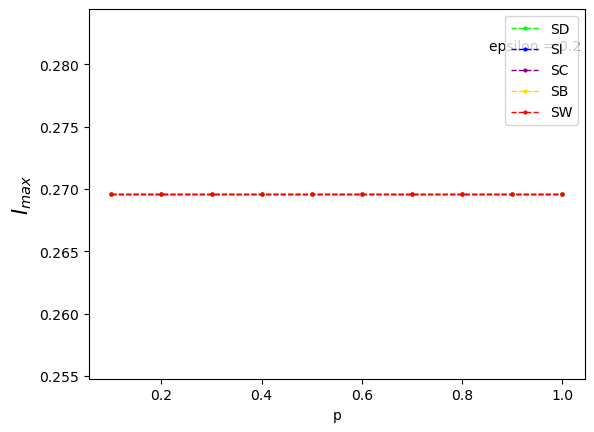

In [60]:

names = ['SD', 'SI', 'SC', 'SB', 'SW']
Imax = np.array(results[0])
# convert into 2d array
Imax = Imax.reshape(step,len(P))
# colors are green blue dark yellow red and black
colors = ['#00FF00', '#0000FF', '#8B008B', '#FFD700', '#FF0000', '#000000']
for j in range(len(P)):
    plt.plot(np.linspace(1,step,step)/10, Imax[:,j]/(100*n), label=names[j], color=colors[j],marker='o', markersize=2,linestyle='dashed', linewidth=1)
plt.legend()
plt.xlabel('p')
plt.ylabel('$I_{max}$',size=15)
# add text
plt.text(0.9, 0.9, f'epsilon = {e}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.show()


### $Z_{FOS}$

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Asus pc\AppData\Local\Temp\ipykernel_7316\2517180568.py:38: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(M) # adjacency matrix
100%|██████████| 10/10 [00:48<00:00,  4.81s/it]


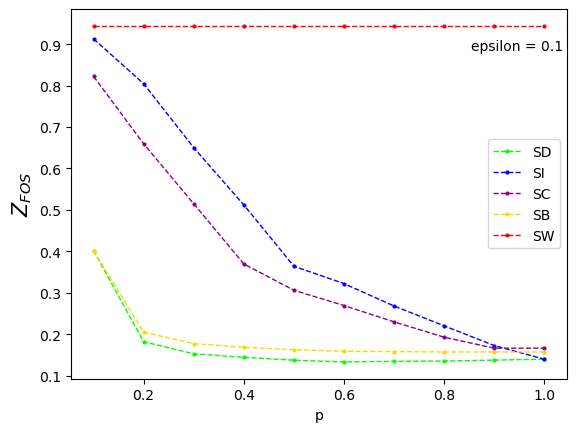

100%|██████████| 10/10 [01:11<00:00,  7.15s/it]


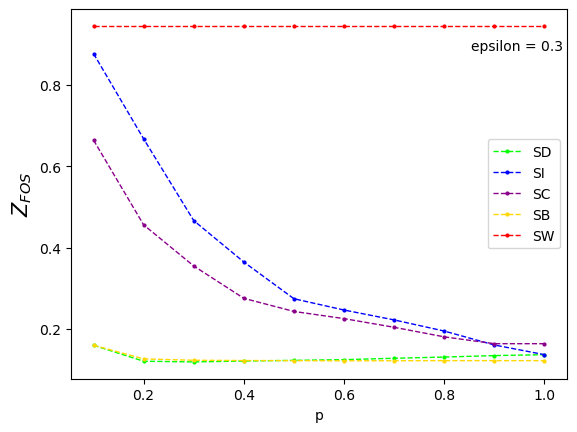

100%|██████████| 10/10 [01:20<00:00,  8.06s/it]


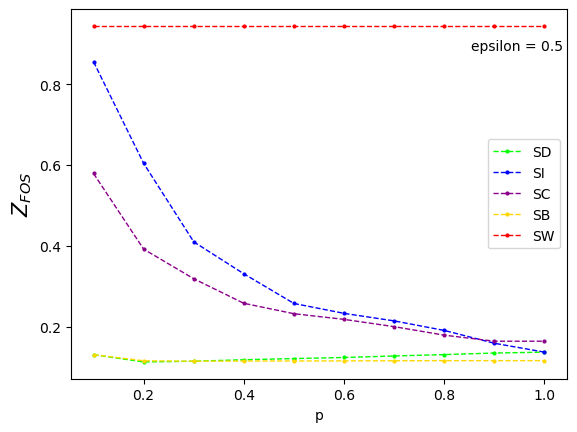

In [5]:
m = 5 # avg degree
n = 10 # number of communities
M = nx.barabasi_albert_graph(n, m)
e = 0.2 # migration strength
s0 = []
temp = [0.99, 0.01, 0, 0, 0]
for i in range(n):
    de = i+1
    temp = [100-de, de, 0, 0, 0]
    s0 = s0 + temp # S, E, I, H, R
# initial conditions for each community in the network
s0.append(0) # K
step = 10

for e in [0.1,0.3,0.5]:
    Z = [] # store all the infected people
    for y in tqdm(range(1,step+1)):
        P = [] # store all the probabilities for SW,SD,SI,SB,SC
        p = np.zeros(n)
        Nd = y/step # fraction of nodes to be provided with kits
        z = int(Nd*sn)

        #------------------------------------------------------------
        temp = np.array(sorted(M.degree(), key=lambda x: x[1], reverse=True)[:z])
        p[temp[:,0]] = temp[:,1]/sum(temp[:,1]) # degree distribution of testkits SD
        P.append(p)
        #------------------------------------------------------------
        p = np.zeros(n)
        temp = np.array(sorted(M.degree(), key=lambda x: x[1], reverse=False)[:z])
        p[temp[:,0]] = temp[:,1]/sum(temp[:,1]) # degree distribution of testkits SI
        P.append(p) 
        #------------------------------------------------------------
        p = np.zeros(n)
        temp = np.array(sorted(np.array(list(nx.clustering(M).items())), key=lambda x: x[1], reverse=True)[:z])
        # print(temp)
        p[temp[:,0].astype(int)] = temp[:,1]/sum(temp[:,1]) # degree distribution of testkits SC
        P.append(p)
        #------------------------------------------------------------
        p = np.zeros(n)
        temp = np.array(sorted(np.array(list(nx.betweenness_centrality(M).items())), key=lambda x: x[1], reverse=True)[:z])
        # print(temp)
        p[temp[:,0].astype(int)] = temp[:,1]/sum(temp[:,1]) # degree distribution of testkits SB
        P.append(p)
        #------------------------------------------------------------
        # print(p)

        t = np.linspace(0, 1000,50) # time
        a1 = 0.3
        P.append(np.zeros(n)) # no distribution of testkits

        temp = np.zeros(len(t))

        for j in range(len(P)):
            p = P[j]
            if j == len(P): # no test kits
                a1 = 0
            # print(j,p)
            # print(p)
            s = odeint(f, s0, t)
            K = s[:,-1]
            s = s[:,:-1]
            temp = np.zeros(len(t))
            for i in range(n):
                y = 5*i
                temp += 100 - s[:,y]
            Z.append(max(temp))

    names = ['SD', 'SI', 'SC', 'SB', 'SW']
    Zfos = np.array(Z)
    Z  
    # convert into 2d array
    Zfos = Zfos.reshape(step,len(P))
    # colors are green blue dark yellow red and black
    colors = ['#00FF00', '#0000FF', '#8B008B', '#FFD700', '#FF0000', '#000000']
    for j in range(len(P)):
        plt.plot(np.linspace(1,step,step)/10, Zfos[:,j]/(100*n), label=names[j], color=colors[j],marker='o', markersize=2,linestyle='dashed', linewidth=1)
    plt.legend()
    plt.xlabel('p')
    plt.ylabel('$Z_{FOS}$',size=15)
    # add text
    plt.text(0.9, 0.9, f'epsilon = {e}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.show()
